In [209]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import time
from skimage.data import binary_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fftn, ifftn, fftshift, ifftshift

from torchdiffeq import odeint, odeint_adjoint

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

In [167]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

from utils import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
method = 'dopri5'
adjoint = False

In [183]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

### Kuramoto

In [4]:
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2
       }
M = 5

kuramoto = Kuramoto(args, method, default_type)
kuramoto.init_state(M)
kuramoto.to(device)

T = 151
t = torch.linspace(0, T//2, T)
t0 = 50
T -= t0

kuramoto.solve(t)
kuramoto.trim(t0)

Elapsed time: 3.30 s


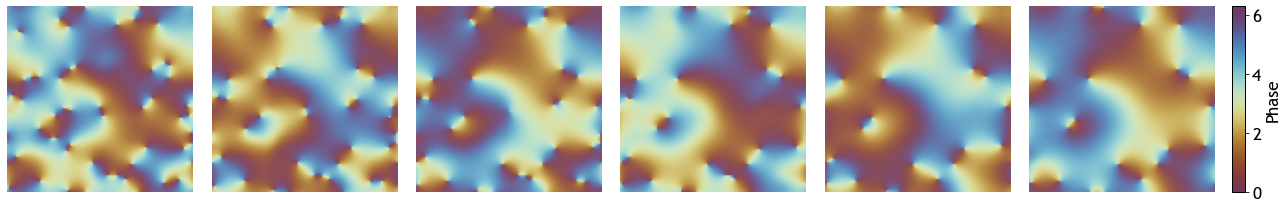

In [5]:
fig = kuramoto.plot_series(kuramoto.y[:,0].cpu().numpy().reshape(-1,kuramoto.N,kuramoto.N),
                           ntype='mod', clabel='Phase')

### Gray-Scott

In [6]:
args = {'N': 200,
        'L': 2.,
        'Du': 1e-5,
        'Dv': 5e-6,
        'f': 0.040,
        'k': 0.063,
        'f0': 0.040,
        'k0': 0.060
       }
M = 1

grayscott = GrayScott(args, method, default_type)
grayscott.init_state(M)
grayscott.to(device)

tf = 2500
T = 6
t = torch.linspace(0, tf, T)

grayscott.init_solve(t)

Elapsed time: 11.01 s


In [7]:
tf = 250
T = 51
t = torch.linspace(0, tf, T)

grayscott.solve(t)

Elapsed time: 1.37 s


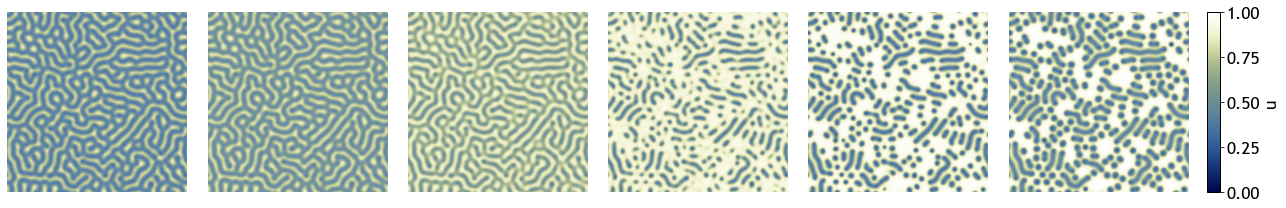

In [8]:
fig = grayscott.plot_series(grayscott.y[:,0,0].cpu().numpy().reshape(-1,grayscott.N,grayscott.N),
                            ntype='unit', clabel='u')

### Lotka-Volterra

In [185]:
args = {'N': 400,
        'L': 4.,
        'R': 0.15,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 10

lv = LotkaVolterra(args, method, default_type)
lv.init_state(M)
lv.to(device)

T = 151
t = torch.linspace(0, T-1, T)

lv.solve(t)

Elapsed time: 0.87 s


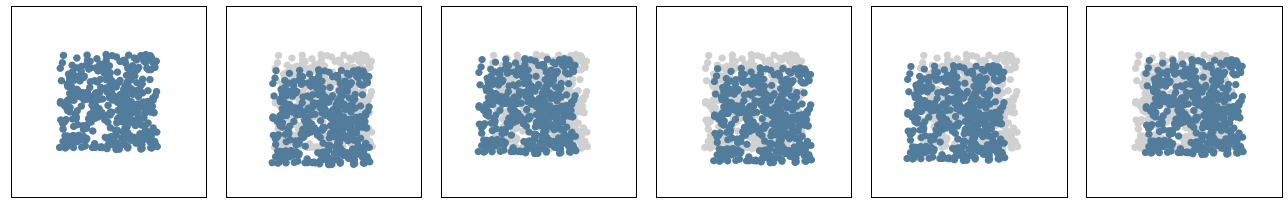

In [186]:
fig = lv.plot_series(lv.y[:,0].cpu().numpy(), ntype='none')

### Kuramoto

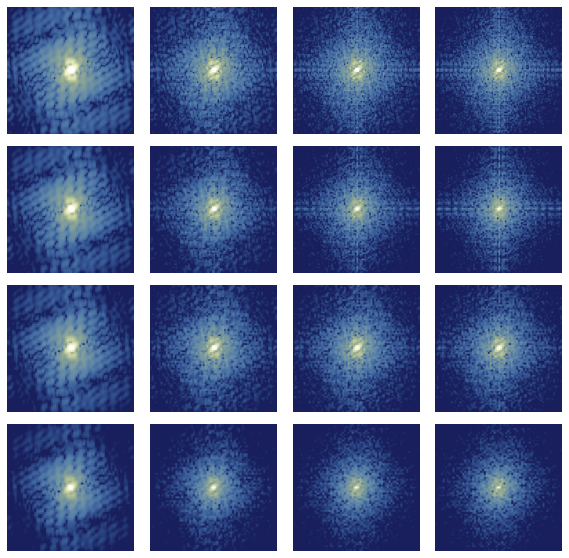

In [14]:
n = 64
f_mask = None
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):
        cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
        kuramoto.plot_frame(ax[i,j], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                            vmin=1e2, vmax=1e8, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


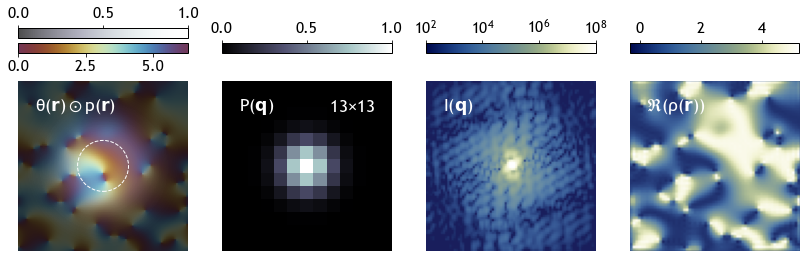

In [15]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = None
cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
cxs.shapes()
fig = cxs.plot_example(kuramoto, kuramoto.y0[0], ntype='mod', vmin=1e2, vmax=1e8)

In [16]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 1, 10000])
 y: torch.Size([20, 10, 1, 10000])
Elapsed time: 0.586 s


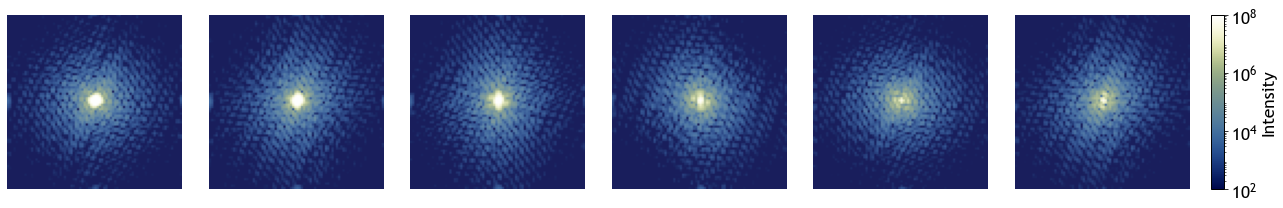

In [17]:
fig = kuramoto.plot_series(Y_batch[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')

### Gray-Scott

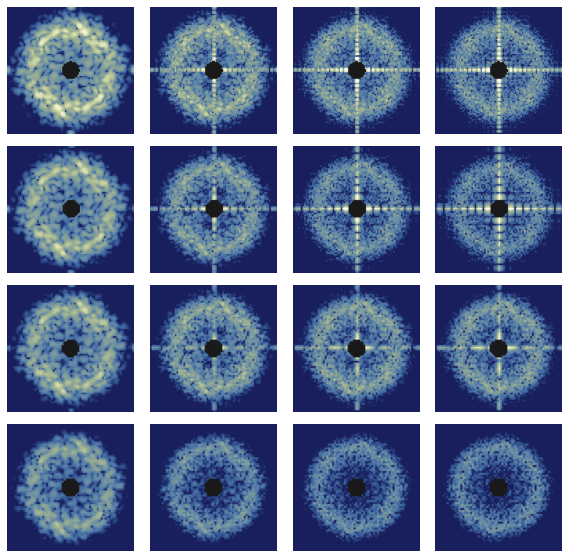

In [18]:
n = 64
f_mask = 0.07
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
        grayscott.plot_frame(ax[i,j], cxs(grayscott.y0[0], pol=1).reshape(cxs.n, cxs.n),
                             vmin=1e2, vmax=1e6, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


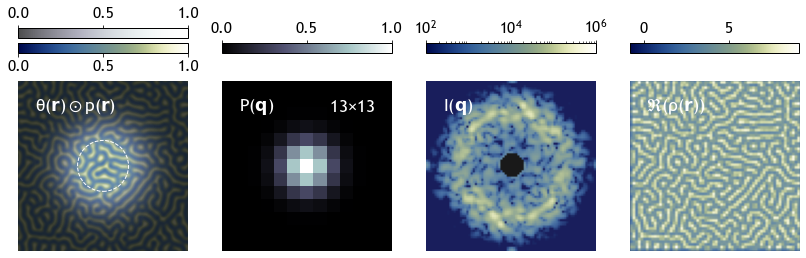

In [19]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.07
cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
cxs.shapes()
fig = cxs.plot_example(grayscott, grayscott.y0[0], ntype='unit', vmin=1e2, vmax=1e6)

In [20]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = grayscott.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 2, 40000])
 y: torch.Size([20, 10, 2, 40000])
Elapsed time: 2.128 s


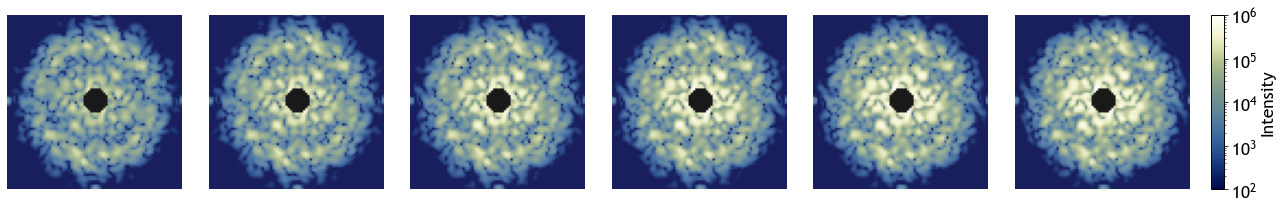

In [21]:
fig = grayscott.plot_series(Y_batch[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                            ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity');

### Lotka-Volterra

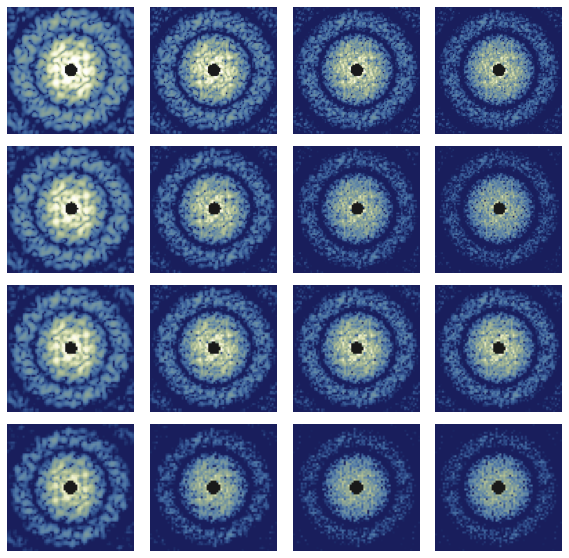

In [143]:
n = 64
f_mask = 0.05
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
        lv.plot_frame(ax[i,j], cxs(lv.y0[0]).reshape(cxs.n, cxs.n), vmin=1, vmax=1e4, ntype='log')

Detector: 80 x 80 	Probe: 13 x 13


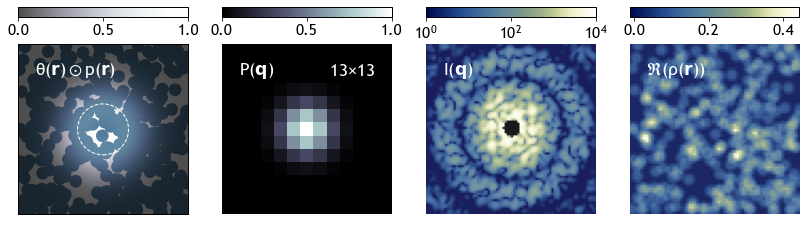

In [187]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.05
cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
cxs.shapes()
fig = cxs.plot_example(lv, lv.y0[0], vmin=1, vmax=1e4)

In [33]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

 t: torch.Size([20])
y0: torch.Size([10, 400, 2])
 y: torch.Size([20, 10, 400, 2])
Elapsed time: 2.618 s


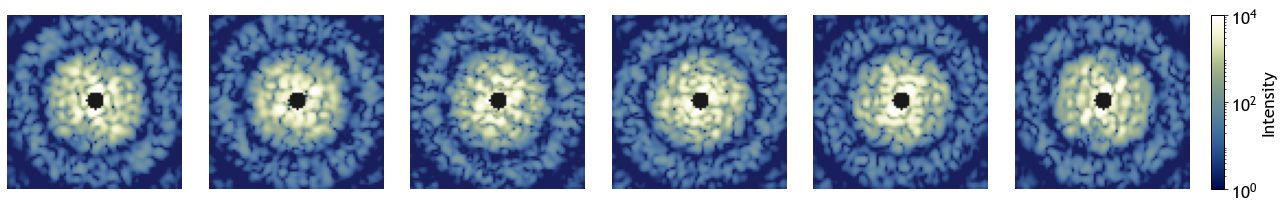

In [34]:
fig = lv.plot_series(Y_batch[:,0].cpu().numpy().reshape(-1,cxs.n,cxs.n),
                     ntype='log', vmin=1, vmax=1e4, clabel='Intensity');

### Kuramoto

In [213]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'v': 0.5,
                        'K': 0.2,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, f='phase')
        
        self.conv = nn.Conv2d(1, 1, 5, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.1)
    
    
    def loss(self, y_true, y_pred, pol=1):
        return nn.L1Loss()(self.cxs(y_true, pol), self.cxs(y_pred, pol))
        
        
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return self.v + self.K*(cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)

In [214]:
method = 'dopri5'
adjoint = False
args = {'N': 100,
        'L': 2.,
        'v': 0.5,
        'K': 0.2,
        'n': 64,
        'dq': 0.8,
        'f_probe': 0.15,
        'f_mask': None,
       }

node = NODE(args, method, adjoint, default_type).to(device)
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

NODE(
  (cxs): CXSGrid(
    (probe): Conv2d(1, 1, kernel_size=(64, 64), stride=(1, 1), padding=same, bias=False)
  )
  (conv): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)


In [223]:
max_iters = 10
chkpt = 1
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

Iteration: 0001 | Total Loss: 9797.499844 | Time: 2.095796
Iteration: 0002 | Total Loss: 9040.237395 | Time: 1.929474
Iteration: 0003 | Total Loss: 10234.006227 | Time: 2.020787
Iteration: 0004 | Total Loss: 10356.233092 | Time: 2.064811
Iteration: 0005 | Total Loss: 8115.056237 | Time: 2.004780
Iteration: 0006 | Total Loss: 11393.981345 | Time: 2.060230
Iteration: 0007 | Total Loss: 7880.730994 | Time: 2.032894
Iteration: 0008 | Total Loss: 7791.192339 | Time: 2.016849
Iteration: 0009 | Total Loss: 10299.016556 | Time: 2.018640
Iteration: 0010 | Total Loss: 8337.642810 | Time: 2.028370


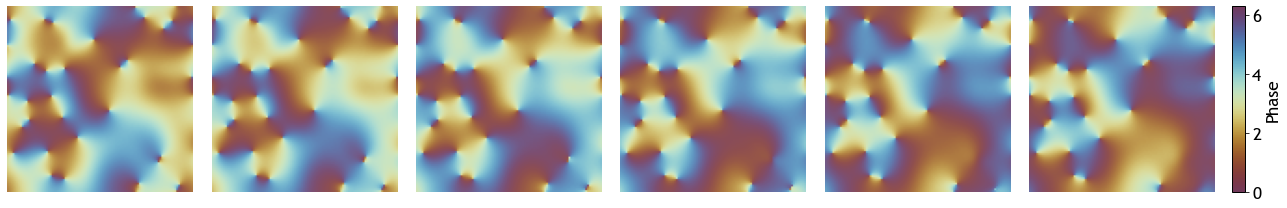

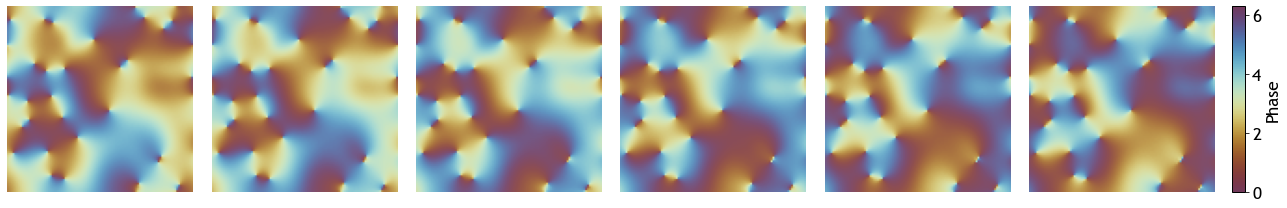

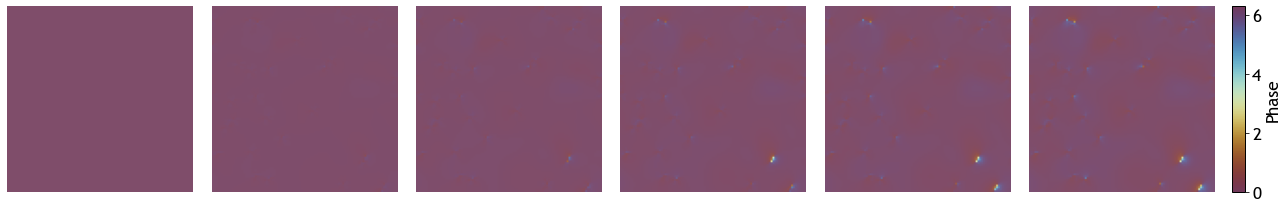

In [224]:
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
y_pred = node.solve(t_batch, y0_batch, device)

fig = node.plot_series(y_batch[:,0].detach().cpu().numpy().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')
fig = node.plot_series(y_pred[:,0].detach().cpu().numpy().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')

diff = y_pred[:,0] - y_batch[:,0]
fig = node.plot_series(diff.detach().cpu().numpy().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')

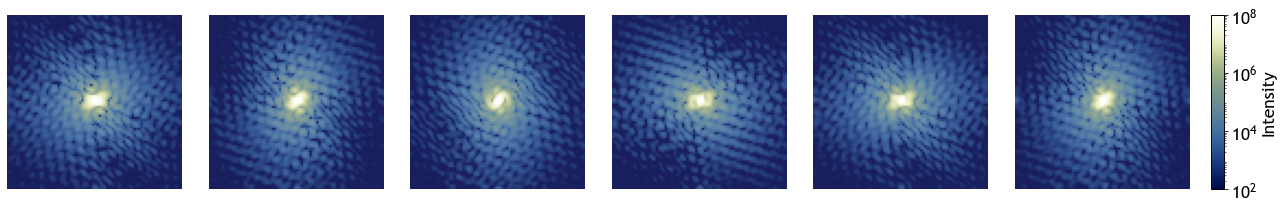

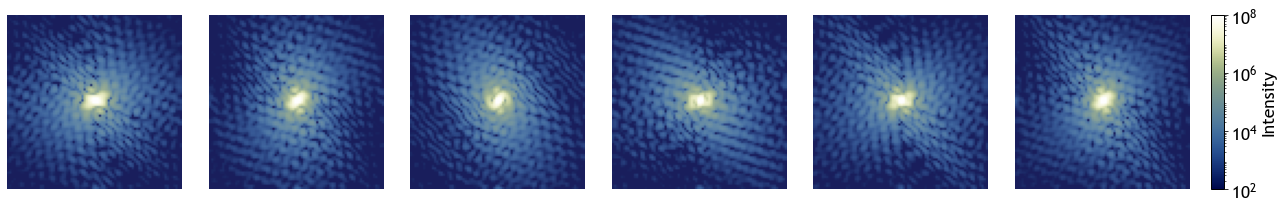

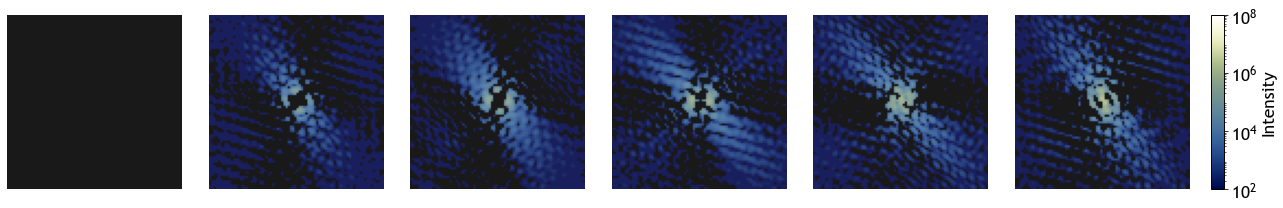

In [225]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e8, clabel='Intensity')

In [188]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'R': 0.05,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSPoint(self.R, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask)
        
        self.A = nn.Linear(2,2)

        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )
    
        #self.init_weights(self.A, std=0.01)
        #self.init_weights(self.F, std=0.01)

        
    def init_weights(self, x, std=0.01):
        for p in x.parameters():
            if p.ndim > 1:
                nn.init.normal_(p, mean=0, std=std)
            else:
                nn.init.uniform_(p, 0, 1)
                
    
    def loss(self, y_true, y_pred):
        return nn.L1Loss()(self.cxs(y_true), self.cxs(y_pred))
        
        
    def forward(self, t, y):
        y_mean = y.mean(dim=-2, keepdims=True)
        dy = self.A(y_mean) + self.F(y_mean)
        return torch.tile(dy, (1, self.N, 1))

In [194]:
method = 'dopri5'
adjoint = False
args = {'N': 400,
        'L': 4.,
        'R': 0.15,
        'n': 64,
        'dq': 0.8,
        'f_probe': 0.15,
        'f_mask': 0.05,
       }

node = NODE(args, method, adjoint, default_type).to(device)
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

NODE(
  (cxs): CXSPoint(
    (probe): Conv2d(1, 1, kernel_size=(64, 64), stride=(1, 1), padding=same, bias=False)
  )
  (A): Linear(in_features=2, out_features=2, bias=True)
  (F): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [198]:
max_iters = 10
chkpt = 1
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

Iteration: 0001 | Total Loss: 151.003102 | Time: 16.008116
Iteration: 0002 | Total Loss: 162.896502 | Time: 10.751198
Iteration: 0003 | Total Loss: 164.976654 | Time: 12.351503
Iteration: 0004 | Total Loss: 156.588582 | Time: 13.911171
Iteration: 0005 | Total Loss: 143.670320 | Time: 8.339481
Iteration: 0006 | Total Loss: 151.986012 | Time: 8.077150
Iteration: 0007 | Total Loss: 153.154200 | Time: 8.435982
Iteration: 0008 | Total Loss: 145.921740 | Time: 8.505205
Iteration: 0009 | Total Loss: 159.519961 | Time: 8.684179
Iteration: 0010 | Total Loss: 146.390743 | Time: 8.279316


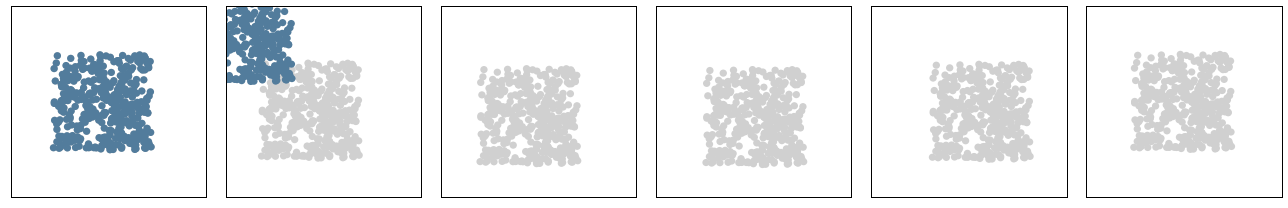

In [199]:
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
y_pred = node.solve(t_batch, y0_batch, device)

fig = node.plot_series([y_batch[:,0].detach().cpu().numpy(), y_pred[:,0].detach().cpu().numpy()], ntype='none')

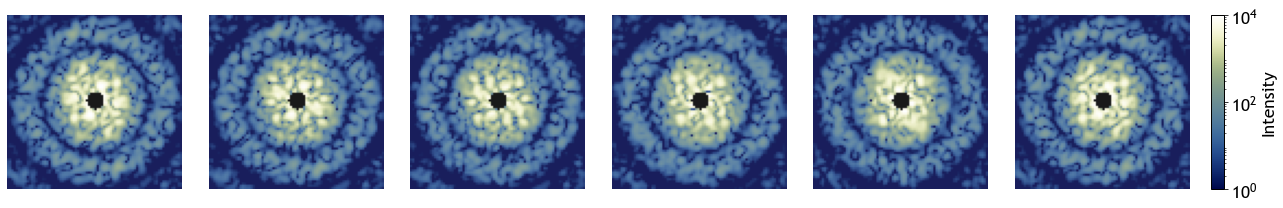

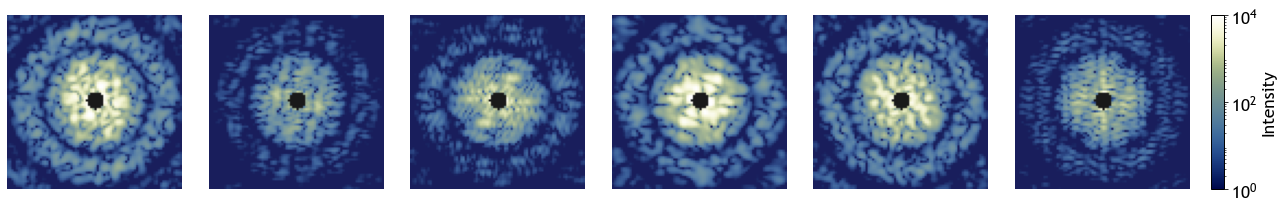

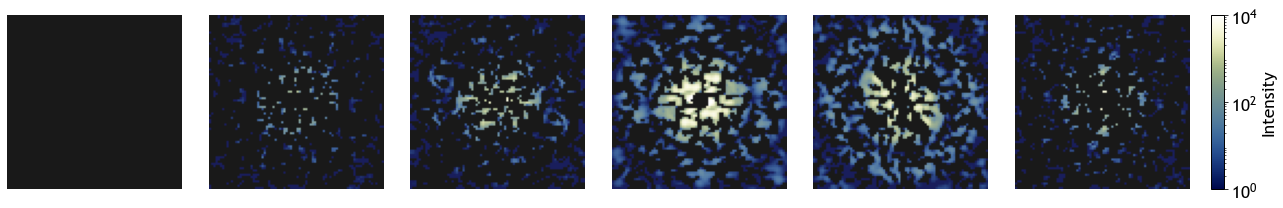

In [200]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1, vmax=1e4, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1, vmax=1e4, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.cpu().numpy().reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1, vmax=1e4, clabel='Intensity')

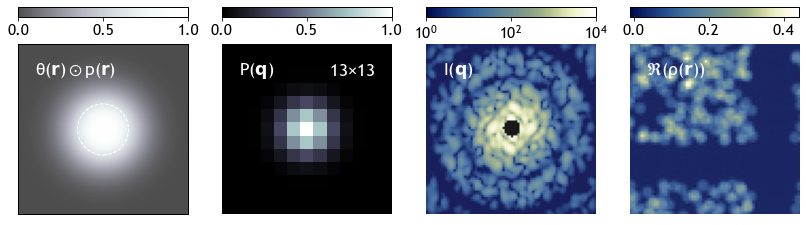

In [201]:
fig = node.cxs.plot_example(node, y_pred[5,0].detach().cpu(), vmin=1, vmax=1e4)